# 7 - Análise Exploratória de Séries Temporais - Faturamento do produto `bonificacao`

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook é uma continuação da análise exploratória inicial.

Neste notebook, vamos progredir para a análise exploratória de séries temporais do faturamento do produto `bonificacao`.

In [1]:
# importação de bibliotecas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# importação de bibliotecas de análise
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae, r2_score

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics
os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'bonificacao'
fat = tswide[analise_produto]
lancamento = tsd[analise_produto].dropna().index[0]

antes_lancto = fat[:lancamento].index

fat = fat.drop(index = antes_lancto)

In [3]:
fat

date
2012-03-01    128793.626312
2012-04-01              NaN
2012-05-01    108098.401122
2012-06-01              NaN
2012-07-01    133967.763827
                  ...      
2021-06-01              NaN
2021-07-01    195188.511222
2021-08-01              NaN
2021-09-01    149130.359732
2021-10-01    175630.723459
Freq: MS, Name: bonificacao, Length: 116, dtype: float64

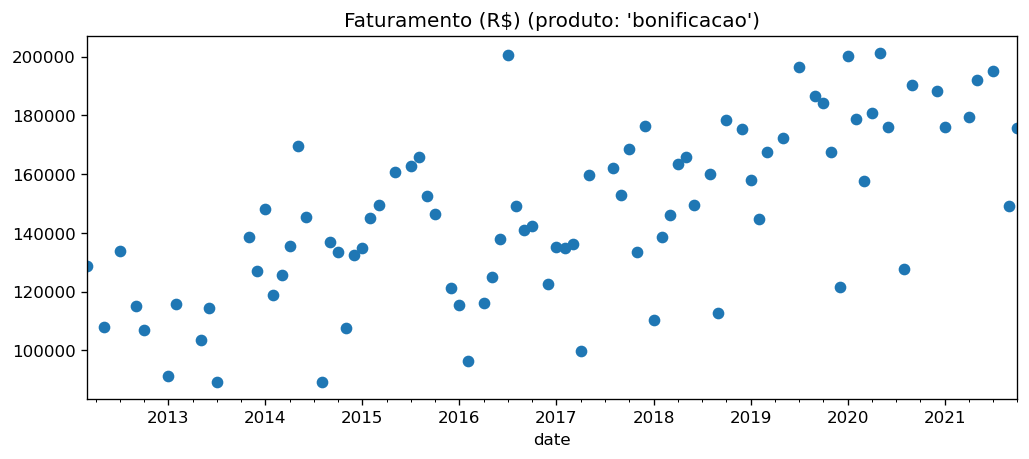

In [4]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [5]:
fat.describe()

count        86.000000
mean     146876.014620
std       28749.544736
min       89211.183185
25%      126109.507134
50%      145913.341145
75%      168398.936689
max      201331.273286
Name: bonificacao, dtype: float64

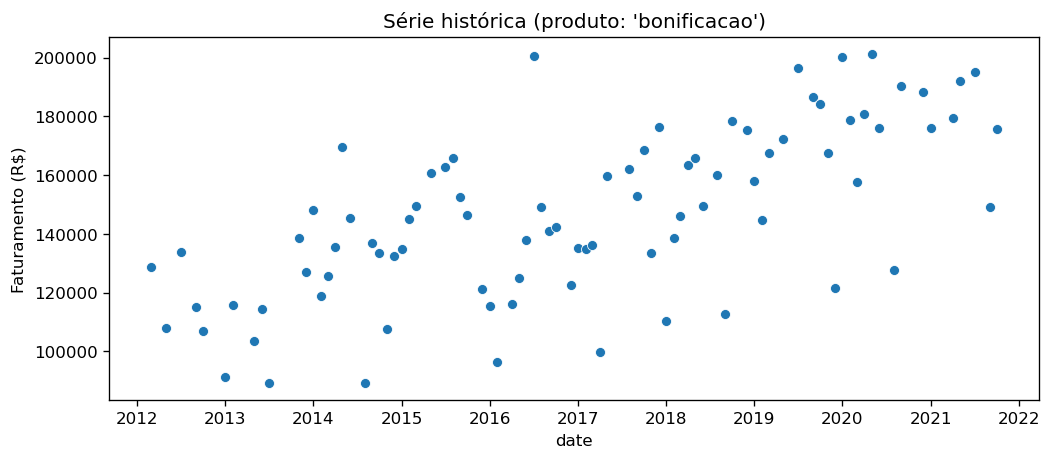

In [6]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

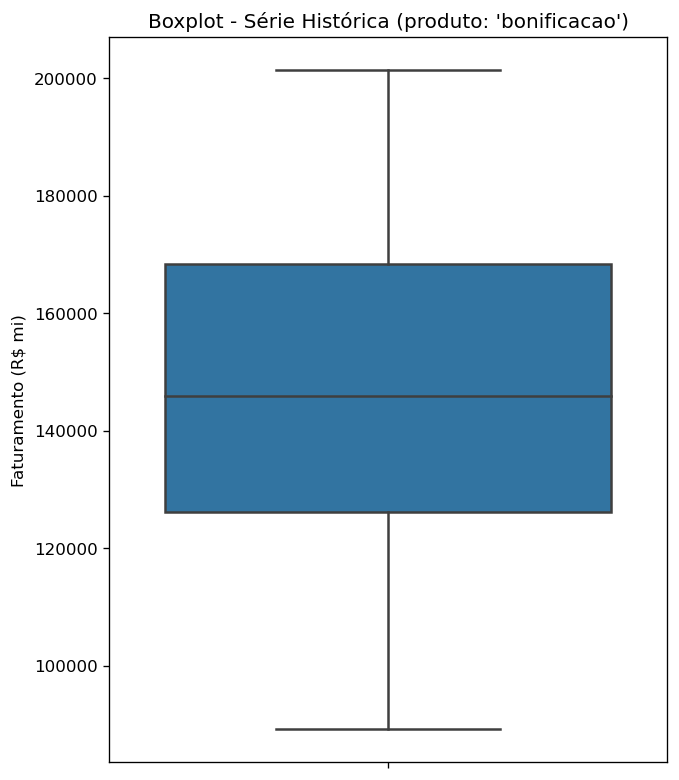

In [7]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$ mi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

Os *outliers* da série histórica indicados no *boxplot* acima são provavelmente decorrentes de a série ser crescente.

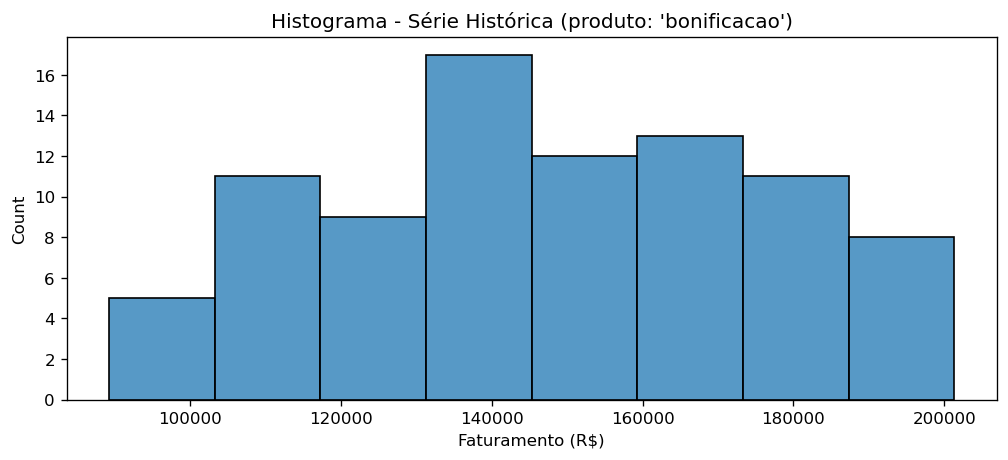

In [8]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa parece bastante comportado. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [9]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count        33.000000
mean     168434.648490
std       22530.819106
min      112903.036433
25%      157559.908526
50%      175503.635972
75%      184069.308917
max      201331.273286
Name: bonificacao, dtype: float64

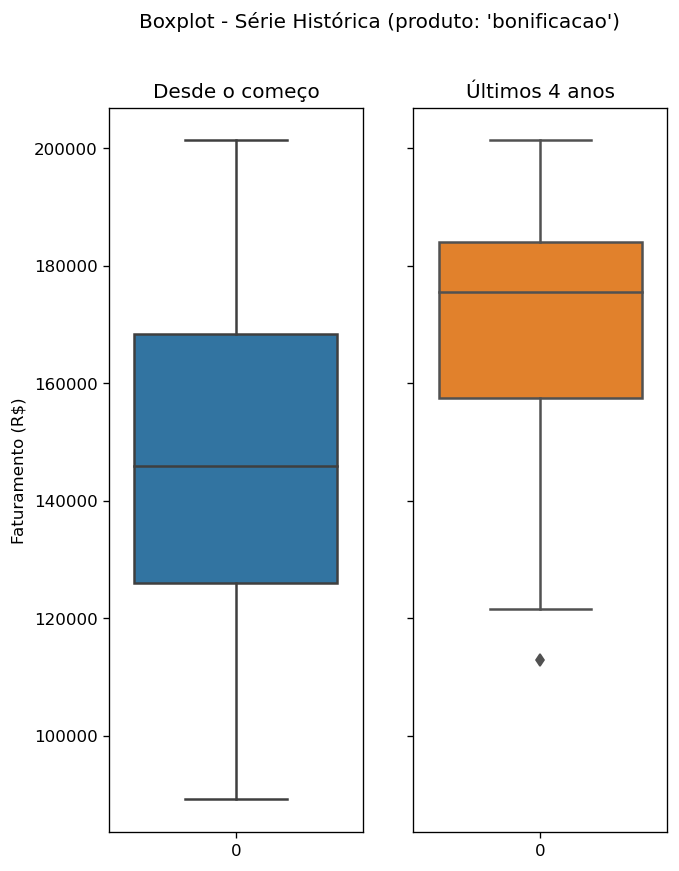

In [10]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

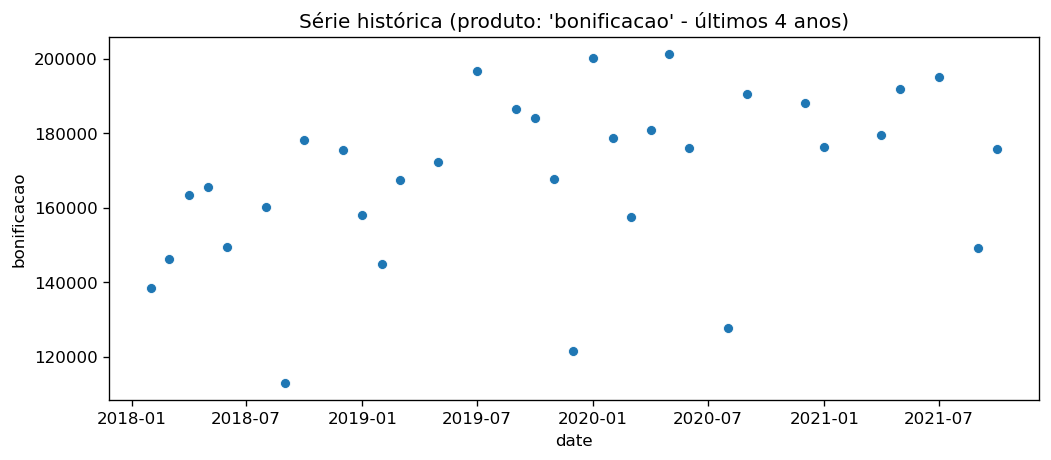

In [11]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

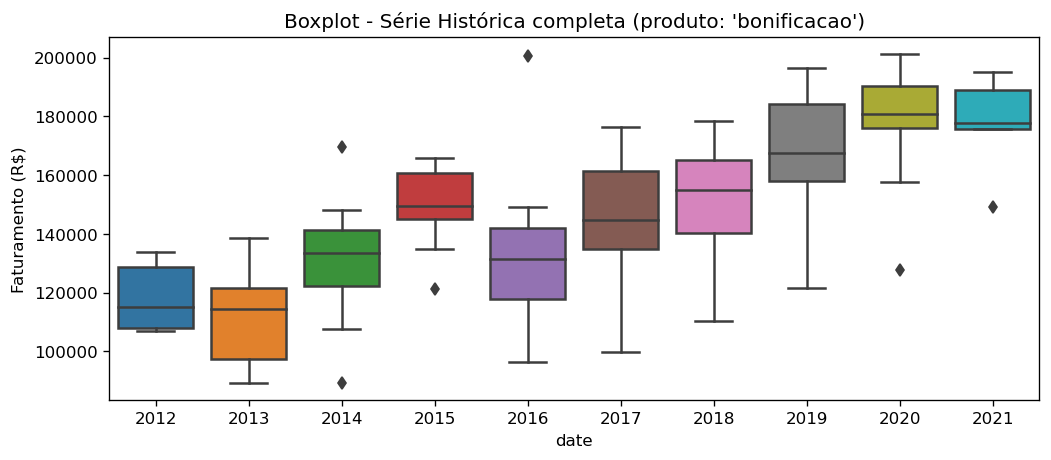

In [12]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

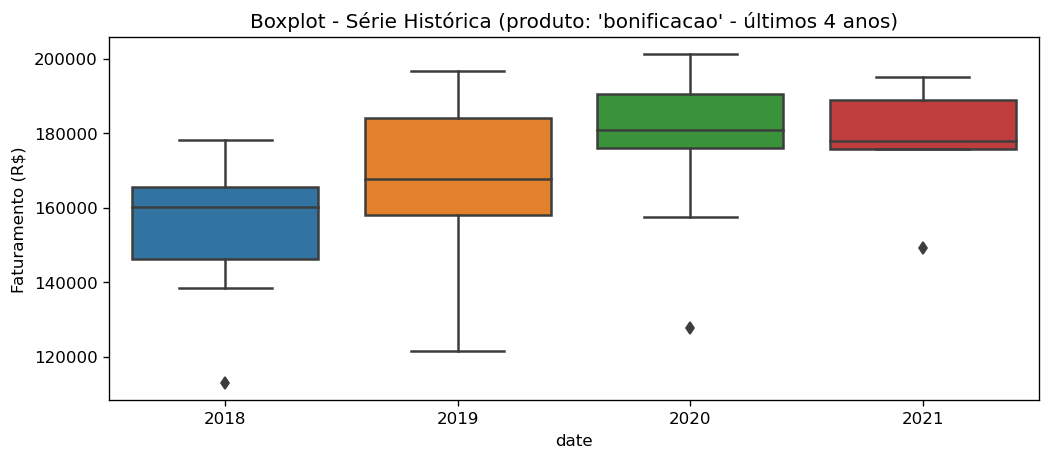

In [13]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [14]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

Nota-se que a série atingiu uma certa estabilidade por volta de meados de 2017:

In [15]:
testedf = adfuller(fat.dropna())
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 72.132% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Confirmamos que a série não é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

In [16]:
i = i_palette[analise_produto]
c = seaborn_palette[i]

decomp = py_scripts.plots.decomp_fourier(serie_fat = fat, produto = analise_produto, c = c)

ValueError: This function does not handle missing values

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

Não é o que ocorre aqui. Os resíduos claramente seguem um padrão oscilatório.

Vamos ver o que ocorre quanto tentamos projetar essa série para o futuro.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

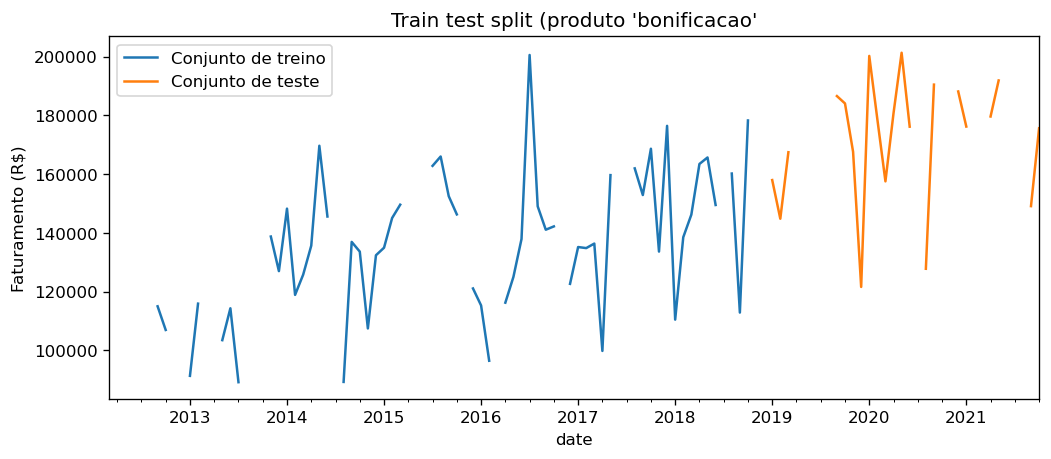

In [ ]:
fat_modelo = fat

train_test_split_idx = int(fat_modelo.shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}'")
plt.ylabel('Faturamento (R$)')
plt.legend()
plt.show()

De cara já determinamos que a série histórica é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) pode ser 0.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

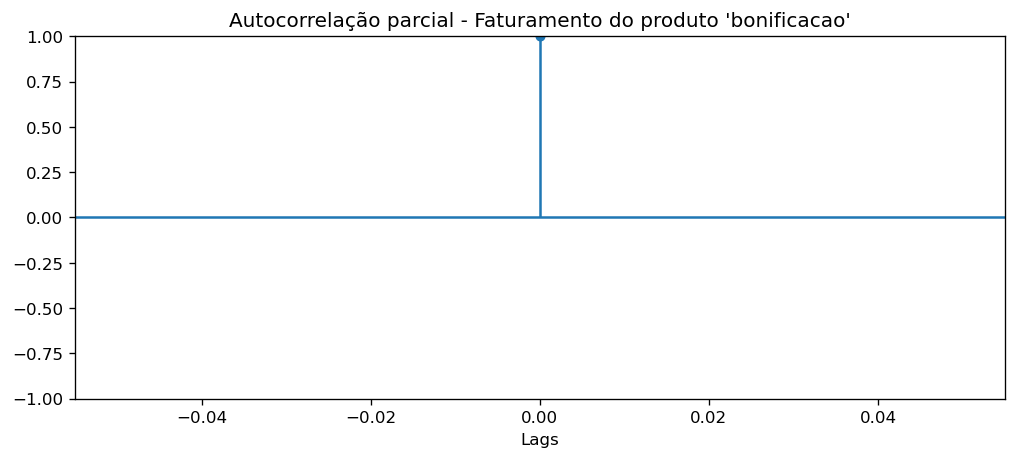

In [ ]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_modelo, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d, D \sim 4$.

In [ ]:
modelo = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = None, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500,
)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# modelos_aceitaveis = [
#     ARIMA(order = (0, 0, 1), seasonal_order=(1, 4, 1, 12), with_intercept = True).fit(y = fat_train),
#     ARIMA(order = (0, 0, 0), seasonal_order=(1, 4, 1, 12), with_intercept = True).fit(y = fat_train)
# ]

In [ ]:
ip = pd.Series(range(0, 3), name = 'p')
id = pd.Series(range(0, 1), name = 'd')
iq = pd.Series(range(0, 3), name = 'q')

iP = pd.Series(range(0, 3), name = 'P')
iD = pd.Series(range(0, 1), name = 'D')
iQ = pd.Series(range(0, 3), name = 'Q')
iS = pd.Series([12], name = 'S')

iIntercept = pd.Series([True, False], name = 'Intercept')

aic_idx = pd.MultiIndex.from_product([ip, id, iq, iP, iD, iQ, iS, iIntercept])

aicdf = pd.DataFrame(
    [], 
    columns = ['aic', 'bic'],
    index = aic_idx
)

aic_min = np.inf

for (p, d, q, P, D, Q, S, intercept) in tqdm(aic_idx, desc = '# de combinações de ordens testadas'):

    if p + q > 3 or P + Q > 3:
        continue
    
    try:
        m = ARIMA(order = (p, d, q), seasonal_order = (P, D, Q, S), with_intercept = intercept, suppress_warnings=True).fit(y = fat_train)
    except:
        continue

    aic = m.aic()
    bic = m.bic()

    if aic < aic_min:
        aic_min = aic
        modelo = m

    #print(f'ARIMA({p}, {d}, {q}): AIC = {aic}, BIC = {bic}')

    aicdf.loc[(p, d, q, P, D, Q, S, intercept)] = (aic, bic)

aicdf.sort_values(by = 'aic')

p

#modelo = ARIMA(order = (0, 1, 0), seasonal_order=(0, 0, 0, 12), with_intercept = True).fit(y = fat_train)

# de combinações de ordens testadas: 100%|██████████| 162/162 [00:35<00:00,  4.56it/s]


2

In [ ]:
# for param in [p, d, q, P, D, Q, S, intercept]:
#     print(f'{param = }')

param = 1
param = 0
param = 1
param = 2
param = 0
param = 1
param = 12
param = False


In [ ]:
aicdf.sort_values(by = 'aic').head(5)

aic          bic
p d q P D Q S  Intercept                          
2 0 0 0 0 0 12 True       1424.343438  1433.970315
    1 0 0 0 12 True       1426.128116  1438.161713
    0 0 0 1 12 True        1426.18334  1438.216936
      1 0 0 12 True       1426.341343   1438.37494
1 0 2 0 0 0 12 True       1427.271672  1439.305268

In [ ]:
modelo = ARIMA(order = (1, 1, 0), with_intercept = True).fit(y = fat_train)

In [ ]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -702.577
Date:                Thu, 18 Nov 2021   AIC                           1411.154
Time:                        21:54:07   BIC                           1418.337
Sample:                             0   HQIC                          1414.036
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2689.3318   3095.905      0.869      0.385   -3378.531    8757.194
ar.L1         -0.5628      0.130     -4.334      0.000      -0.817      -0.308
sigma2      6.175e+08      0.009    6.6e+10      0.000    6.18e+08    6.18e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                 9.98
Prob(Q):                              0.23   Prob(JB):                         0.01
Heteroskedasticity (H):               2.32   Skew:                            -0.06
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.37e+27. Standard errors may be unstable.
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

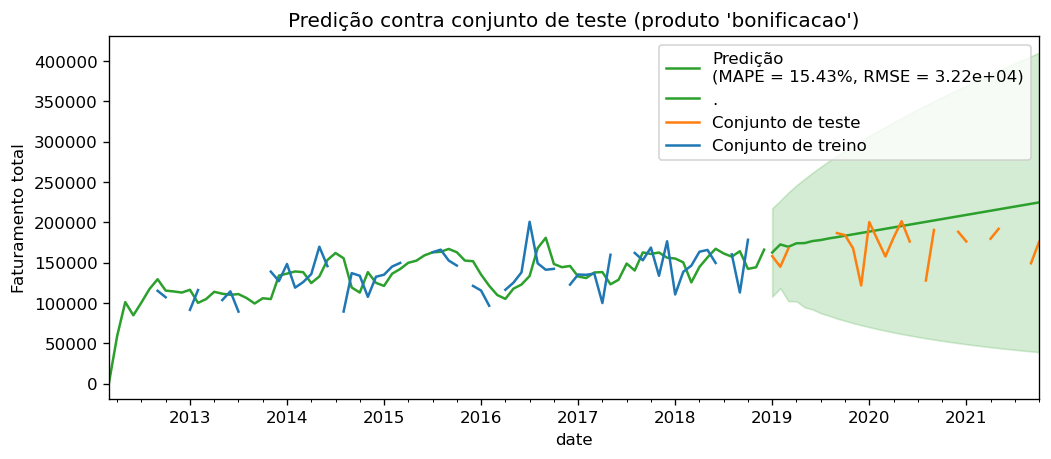

In [ ]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = True,
    preds_metrics = True
)

Vamos aplicar alguns diagnósticos aos resíduos do modelo:

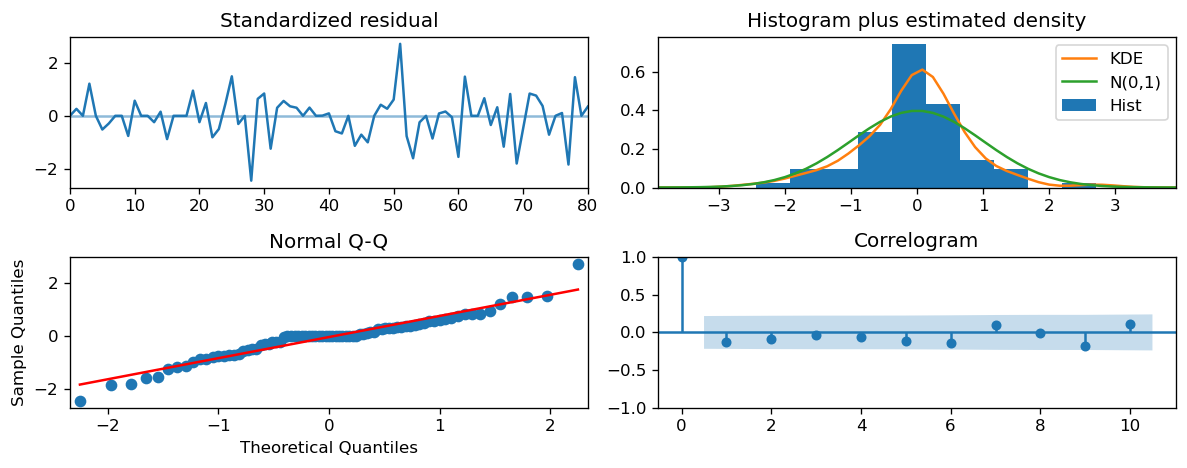

In [ ]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas quantitativas ao modelo:

In [ ]:
kwargs_total = dict(
    y_true = fat_test.dropna(),
    y_pred = preds.loc[fat_test.dropna().index],
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 15.434%
       RMSE: 3.220e+04
        MAE: 2.428e+04


In [ ]:
from sklearn.linear_model import LinearRegression

X = fat.index
y = fat
bnousreg = LinearRegression()